# NLP Super Stars --  A Natural Language Processing Project
Jared Vahle, Joshua Bryant, Hector Rodriguez, Sarah Lawson Woods - November 2021

In [1]:
import requests
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pprint import pprint

from wordcloud import WordCloud
from modeling import *

import os
import json

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from prepare import *

import nltk
import nltk.sentiment

import warnings


In [2]:
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Acquire

In [3]:
data = pd.read_json('data.json')

In [4]:
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


### Acquire Takeaway
- The data was acquired by scaping the starred repos on GitHub 
- We brought in 506 rows initially 

# Prepare

In [5]:
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [6]:
# removed languages that were 'none'
data = data.dropna()

In [7]:
len(data)

506

In [8]:
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Swift                13
Shell                13
HTML                 12
Rust                 11
C#                    9
Kotlin                9
Ruby                  9
Vim script            6
PHP                   6
Jupyter Notebook      6
Vue                   6
CSS                   5
Objective-C           3
CoffeeScript          2
TeX                   2
Haskell               2
Elixir                2
Lua                   2
Batchfile             1
OCaml                 1
Clojure               1
Emacs Lisp            1
Standard ML           1
Dart                  1
Makefile              1
Crystal               1
Dockerfile            1
Rascal                1
AsciiDoc              1
Name: language, dtype: int64

In [9]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [10]:
len(data)

357

### Language Counts

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

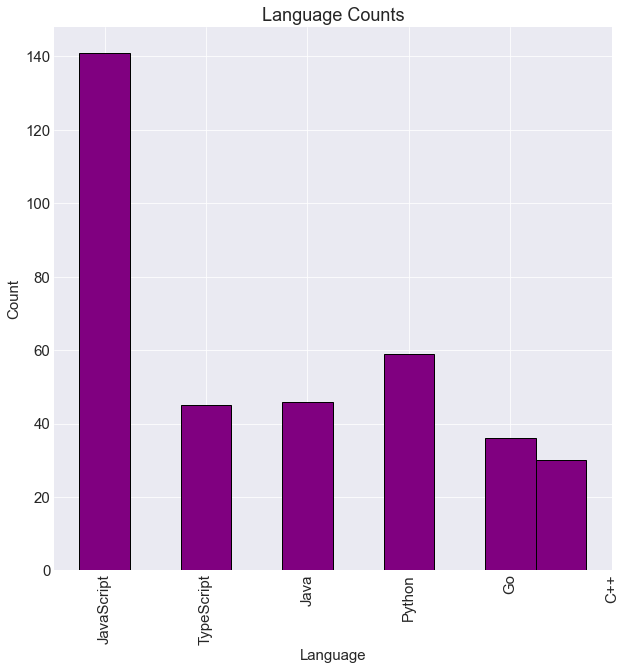

In [78]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'left', color = 'purple', ec = 'k')#I tried to set the 'rwdidth = .9' to narrow the bar width, but when I did we lose 'C++'. To compensate I changed the tick lable alignment and still lost C++.
plt.title('Language Counts')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 90)#I rotated the x lables, but when I did the list below poped up. Not sure how to get rid of it.

In [12]:
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [13]:
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

In [14]:
data = data.drop(columns = ['readme_contents'])

In [15]:
data = get_columns(data)

In [16]:
def is_javascript(row):
    if row['language'] == 'JavaScript':
        return True
    else:
        return False

In [17]:
data['is_javascript'] = data.apply(lambda row: is_javascript(row), axis=1)

In [18]:
data['sentiment'] = data.clean.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [19]:
data

,repo,language,clean,stemmed,lemmatized,message_length,word_count,avg_word_length,is_javascript,sentiment
3,tailwindlabs/tailwindcss,JavaScript,utilityfirst cs framework rapidly building cus...,utilityfirst cs framework rapidli build custom...,utilityfirst c framework rapidly building cust...,549,48,11.437500,True,0.9349
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...,1882,209,9.004785,True,0.8481
7,ianstormtaylor/slate,TypeScript,completely customizable framework building ric...,complet customiz framework build rich text edi...,completely customizable framework building ric...,7461,718,10.391365,False,0.9986
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,3120,311,10.032154,True,0.8720
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,2027,74,27.391892,False,0.9729
...,...,...,...,...,...,...,...,...,...,...
551,TheAlgorithms/Java,Java,httpsgithubcomthealgorithmsjavatreedevelopment...,httpsgithubcomthealgorithmsjavatreedevelop jav...,httpsgithubcomthealgorithmsjavatreedevelopment...,4485,243,18.456790,False,0.0000
555,tornadoweb/tornado,Python,tornado web server image httpsbadgesgitterimjo...,tornado web server imag httpsbadgesgitterimjoi...,tornado web server image httpsbadgesgitterimjo...,911,92,9.902174,False,0.6808
557,gulpjs/gulp,JavaScript,streaming build system npm versionnpmimagenpmu...,stream build system npm versionnpmimagenpmurl ...,streaming build system npm versionnpmimagenpmu...,6677,734,9.096730,True,0.9963
558,alibaba/weex,C++,weex framework building mobile crossplatform u...,weex framework build mobil crossplatform ui bu...,weex framework building mobile crossplatform u...,807,43,18.767442,False,0.6124


# Explore 

In [20]:
data.language.value_counts(normalize = True)

JavaScript    0.394958
Python        0.165266
Java          0.128852
TypeScript    0.126050
Go            0.100840
C++           0.084034
Name: language, dtype: float64

In [21]:
data.language.value_counts()

JavaScript    141
Python         59
Java           46
TypeScript     45
Go             36
C++            30
Name: language, dtype: int64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 3 to 559
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   repo             357 non-null    object 
 1   language         357 non-null    object 
 2   clean            357 non-null    object 
 3   stemmed          357 non-null    object 
 4   lemmatized       357 non-null    object 
 5   message_length   357 non-null    int64  
 6   word_count       357 non-null    int64  
 7   avg_word_length  355 non-null    float64
 8   is_javascript    357 non-null    bool   
 9   sentiment        357 non-null    float64
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 28.2+ KB


In [23]:
data.describe()

,message_length,word_count,avg_word_length,sentiment
count,357.000000,357.000000,355.000000,357.000000
mean,8929.117647,829.109244,11.917034,0.819141
std,17912.084390,1612.111164,4.654157,0.412686
min,0.000000,0.000000,5.849530,-0.995700
25%,2336.000000,194.000000,9.107213,0.927400
50%,4041.000000,364.000000,10.483871,0.989000
75%,7300.000000,734.000000,13.129932,0.996400
max,141410.000000,13110.000000,41.034483,1.000000


In [24]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [25]:
# combine all messages in single string by label

JavaScript_words = clean(' '.join(data[data.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(data[data.language == 'Python'].stemmed))
TS_words = clean(' '.join(data[data.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(data[data.language == 'Java'].stemmed))
Go_words = clean(' '.join(data[data.language == 'Go'].stemmed))
C_words = clean(' '.join(data[data.language == 'C++'].stemmed))
Non_JavaScript = clean(' '.join(data[data.language != 'JavaScript'].stemmed))
all_words = clean(' '.join(data.stemmed))

In [26]:
# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [27]:
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

use                                                                                               318
const                                                                                             168
react                                                                                             131
redux                                                                                             126
function                                                                                          121
                                                                                                 ... 
codecovhttpscodecovioghreactdndreactdndbranchmaingraphbadgesvghttpscodecovioghreactdndreactdnd      1
waiaria                                                                                             1
starterkit                                                                                          1
lifecycl                                                                          

In [28]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
non_JavaScript_freq = pd.Series(Non_JavaScript.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [29]:
word_counts = pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq,non_JavaScript_freq, all_words_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['javascript','python','java','go','c','ts','NonJS','all']
word_counts.head()

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
javascript,837,42,3,1,2,58,106,943
code,792,209,94,65,71,77,516,1308
function,790,151,19,43,82,121,416,1206
j,772,7,2,7,48,94,158,930


In [30]:
word_counts.sort_values('all', ascending = False).head(20)

,javascript,python,java,go,c,ts,NonJS,all
use,1455,857,181,269,312,318,1937,3392
file,705,526,54,166,109,38,893,1598
instal,480,568,49,141,125,103,986,1466
code,792,209,94,65,71,77,516,1308
support,478,325,124,99,117,91,756,1234
function,790,151,19,43,82,121,416,1206
project,672,160,97,51,54,92,454,1126
1,353,339,74,113,137,89,752,1105
option,578,360,16,66,27,38,507,1085
run,418,254,89,117,64,86,610,1028


In [31]:
word_counts.sort_values(['NonJS','javascript'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
takehom,353,0,0,0,0,0,0,353
onsit,277,0,0,0,0,0,0,277
usa,188,0,0,0,0,0,0,188
uk,159,0,0,0,0,0,0,159
nightmar,120,0,0,0,0,0,0,120
ccxt,119,0,0,0,0,0,0,119
san,118,0,0,0,0,0,0,118
autoprefix,108,0,0,0,0,0,0,108
london,103,0,0,0,0,0,0,103
est,99,0,0,0,0,0,0,99


In [32]:
word_counts.sort_values(['javascript','NonJS'],ascending = [True,False]).head(20)

,javascript,python,java,go,c,ts,NonJS,all
softwareoss,0,750,0,0,0,0,750,750
py,0,253,0,0,0,0,253,253
ycm,0,201,0,0,0,0,201,201
cpp,0,27,0,0,93,0,120,120
cmake,0,21,0,0,60,0,81,81
viper,0,0,0,81,0,0,81,81
viml,0,79,0,0,0,0,79,79
filetyp,0,70,0,3,0,4,77,77
struct,0,0,0,24,49,0,73,73
airflow,0,71,0,0,0,0,71,71


## Top 20

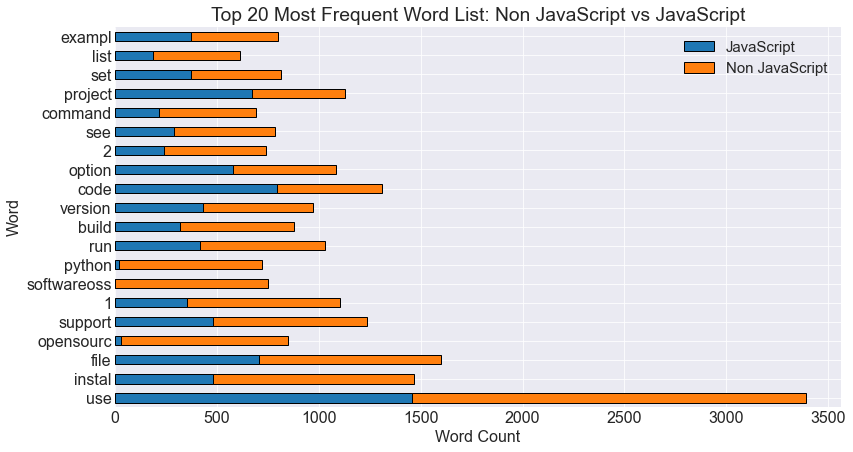

In [33]:
plt.rc('font', size=16)#changed font size
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: Non JavaScript vs JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)#changed the legend labels
plt.show()

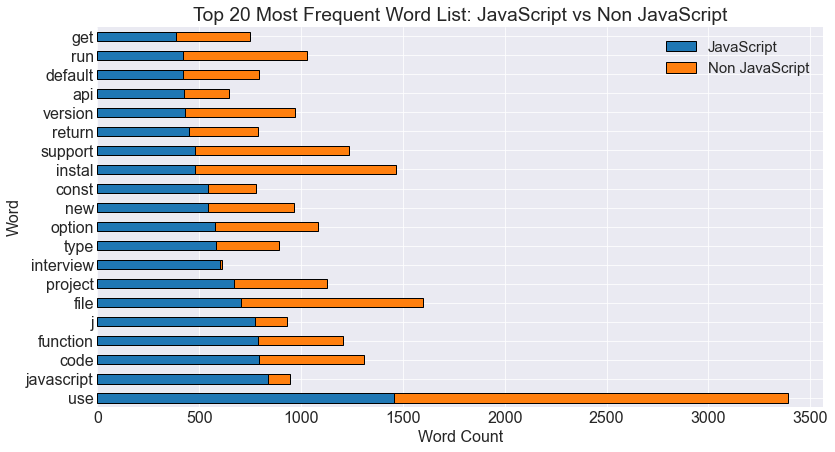

In [34]:
plt.rc('font', size=16)
word_counts.sort_values('javascript', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: JavaScript vs Non JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)#changed the legend labels
plt.show()

## Top 20 Distribution

<Figure size 1152x648 with 0 Axes>

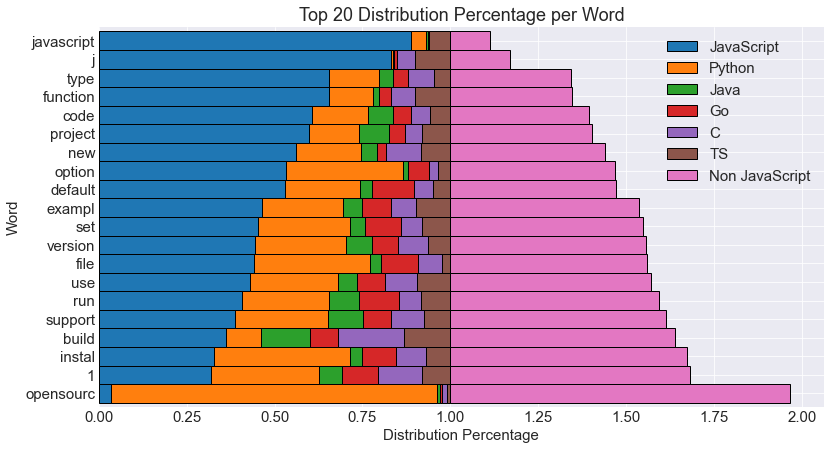

In [35]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=15)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('Top 20 Distribution Percentage per Word')#changed title
plt.xlabel('Distribution Percentage')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Python', 'Java', 'Go', 'C', 'TS', 'Non JavaScript'])#changed the legend labels
plt.show()

## Bigrams

Text(0, 0.5, 'bigrams')

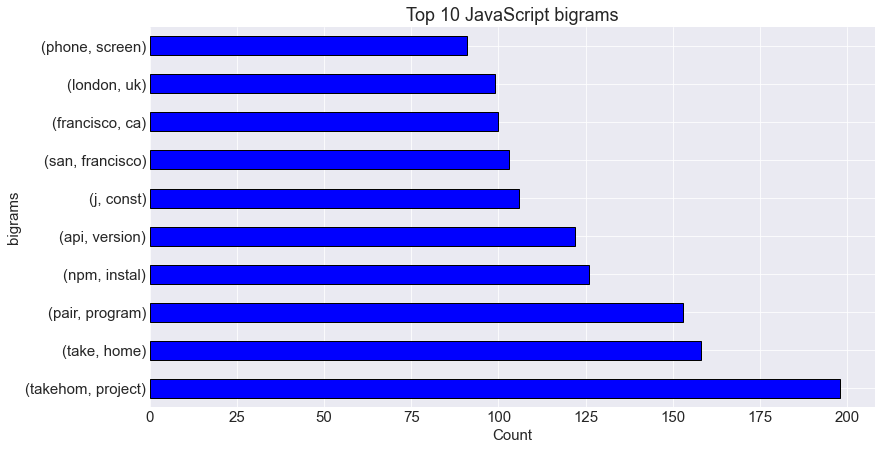

In [36]:
pd.Series(nltk.bigrams(JavaScript_words.split())).value_counts().head(10).plot.barh(color = 'blue',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')

Text(0, 0.5, 'bigrams')

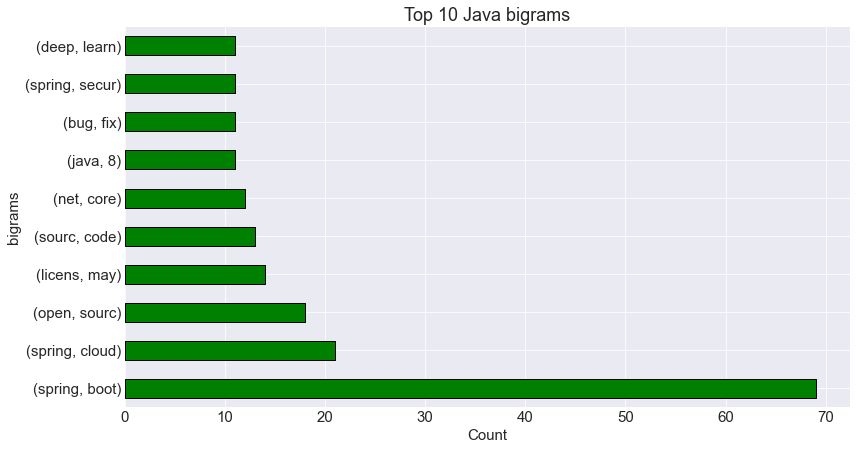

In [37]:
pd.Series(nltk.bigrams(Java_words.split())).value_counts().head(10).plot.barh(color = 'green',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Java bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')

Text(0, 0.5, 'bigrams')

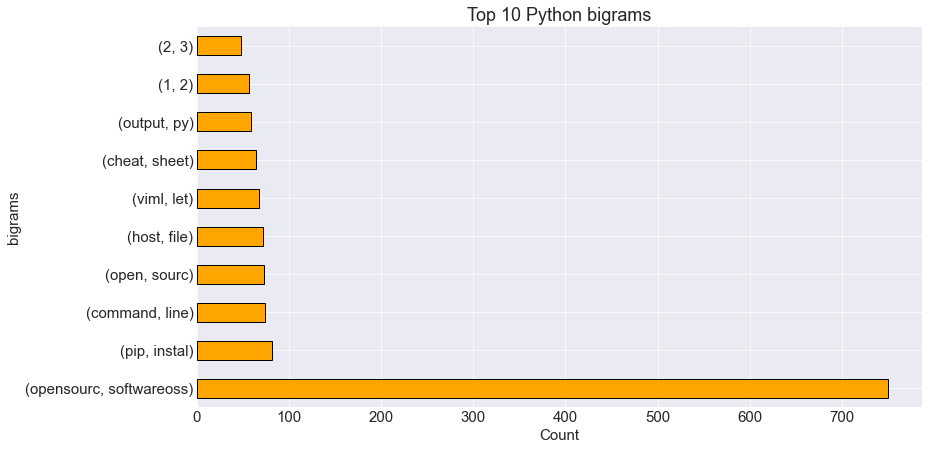

In [38]:
pd.Series(nltk.bigrams(Python_words.split())).value_counts().head(10).plot.barh(color = 'orange',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Python bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')

Text(0, 0.5, 'bigrams')

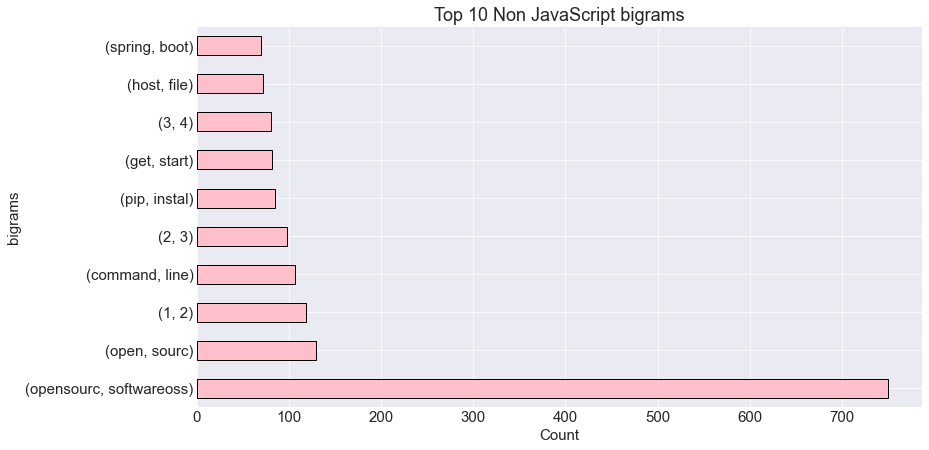

In [39]:
pd.Series(nltk.bigrams(Non_JavaScript.split())).value_counts().head(10).plot.barh(color = 'pink',ec = 'k')#change bar color to reflect distribution chart above and outline
plt.title('Top 10 Non JavaScript bigrams')#change title
plt.xlabel('Count')
plt.ylabel('bigrams')

## Clouds

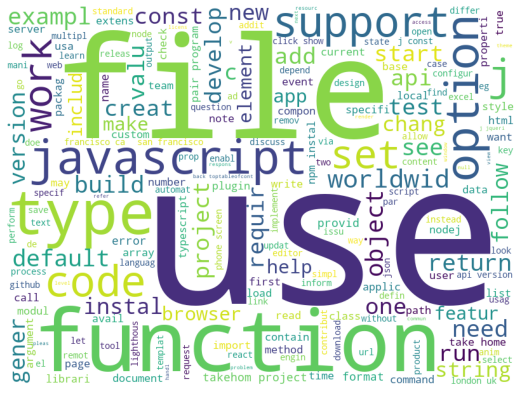

In [40]:
img = WordCloud(background_color='white', width=800, height=600).generate(JavaScript_words)
plt.imshow(img)
plt.axis('off')
plt.show()

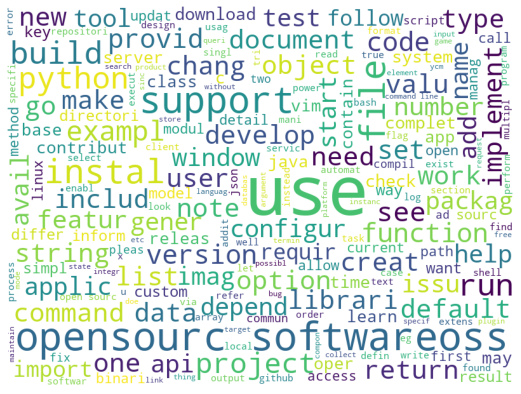

In [41]:
img = WordCloud(background_color='white', width=800, height=600).generate(Non_JavaScript)
plt.imshow(img)
plt.axis('off')
plt.show()

## Relational Plots

### Language Relationships

Text(21.09951171875001, 0.5, 'Word Count')

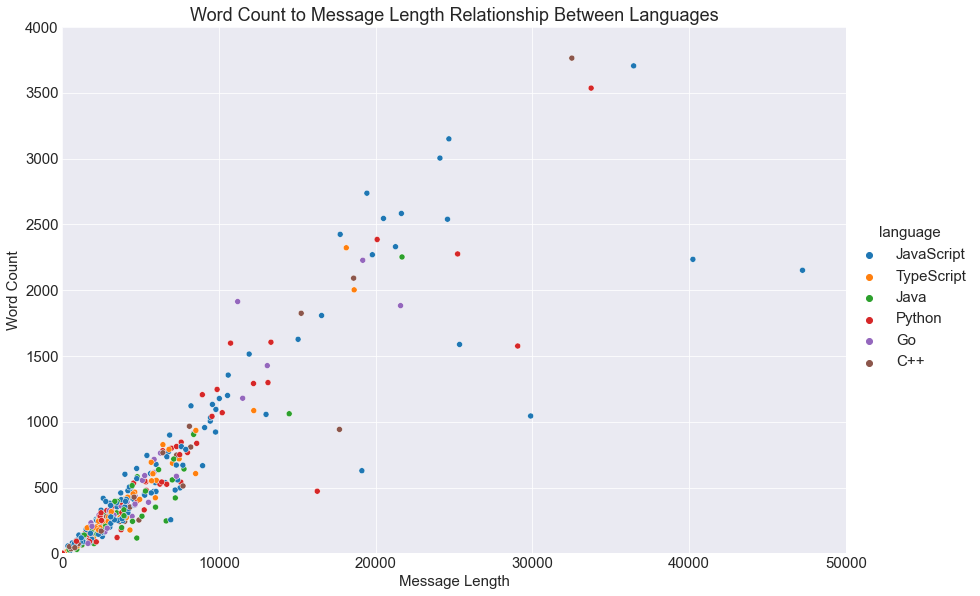

In [42]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Between Languages')#change title
plt.xlabel('Message Length')
plt.ylabel('Word Count')

#### Language Narrowed in Limits

Text(21.09951171875001, 0.5, 'Word Count')

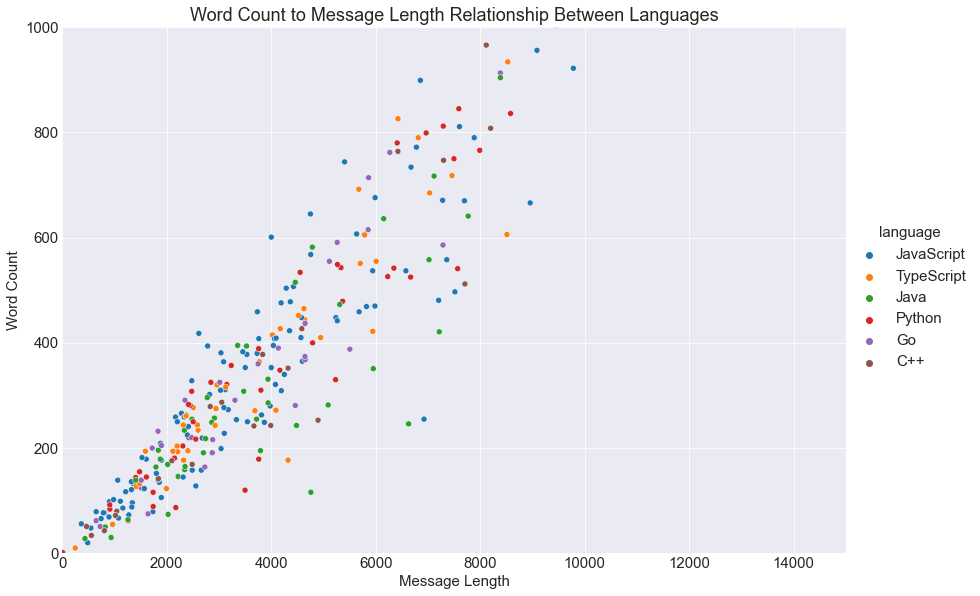

In [43]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Between Languages')#change title
plt.xlabel('Message Length')
plt.ylabel('Word Count')

### JavaScript Relationships

Text(18.93476562500001, 0.5, 'Word Count')

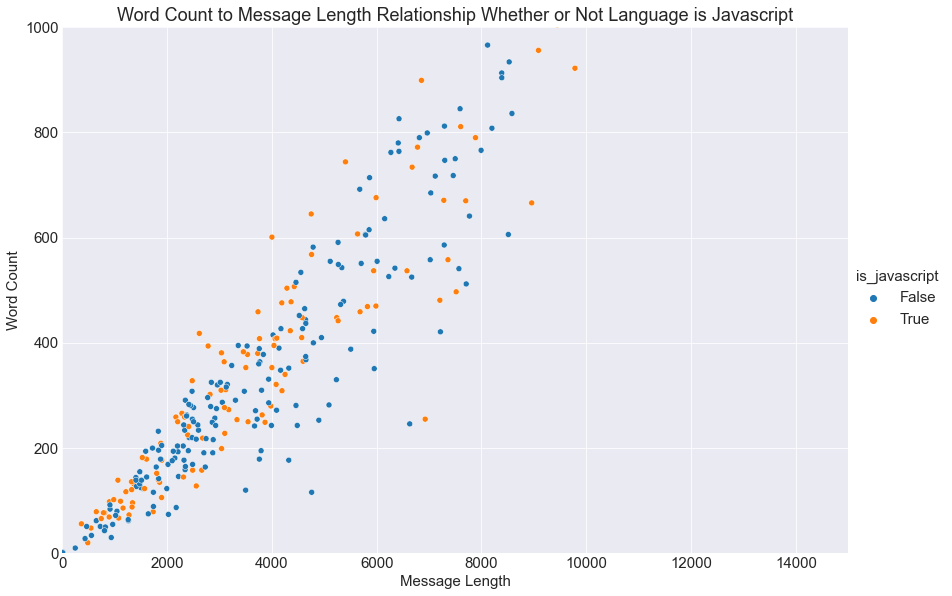

In [44]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')#change title
plt.xlabel('Message Length')
plt.ylabel('Word Count')

#### Is_JavaScript Narrowed in limits

Text(18.93476562500001, 0.5, 'Word Count')

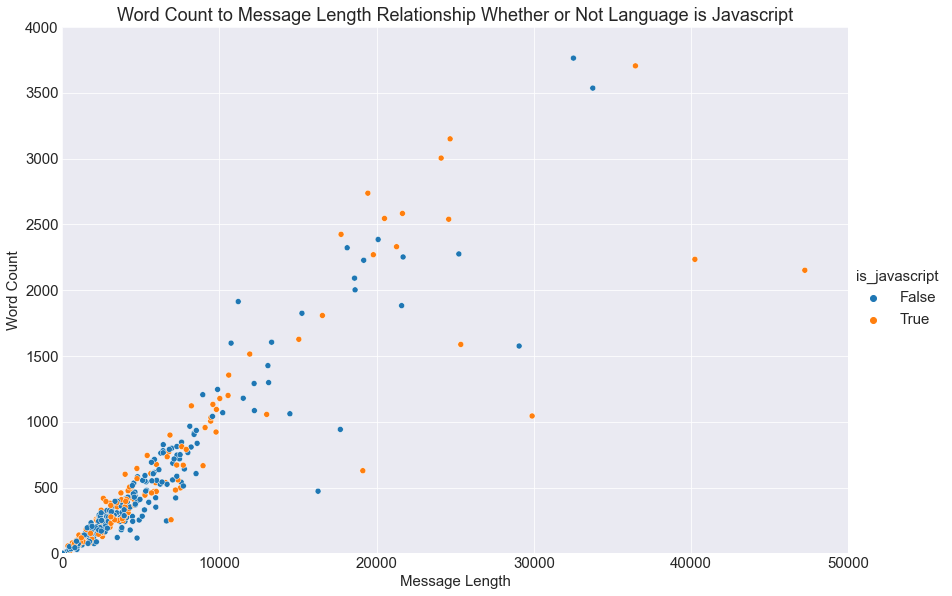

In [45]:
plot = sns.relplot(data = data, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')#change title
plt.xlabel('Message Length')
plt.ylabel('Word Count')

### Average Word Relationships

Text(21.09951171875001, 0.5, 'Word Count')

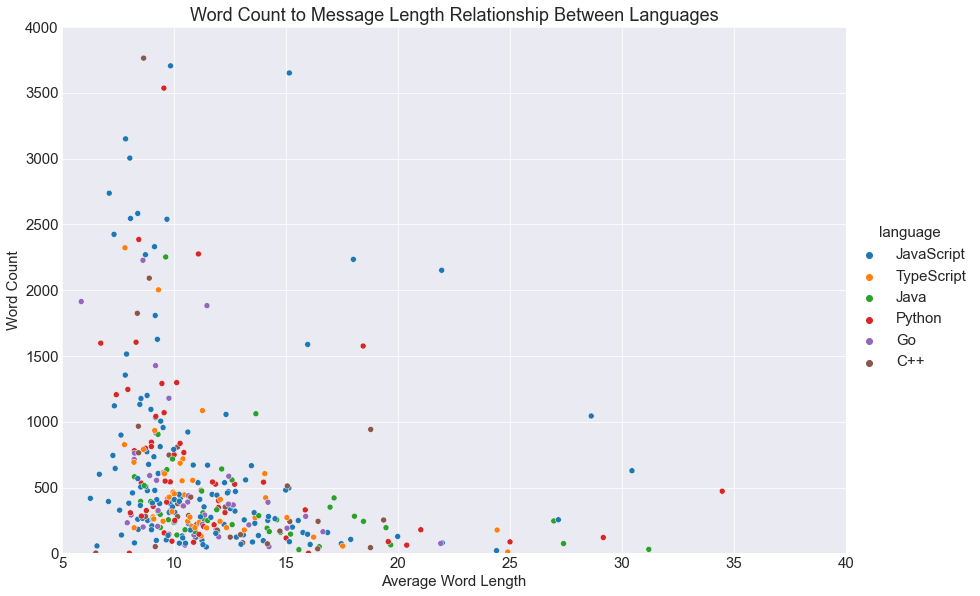

In [46]:
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(5,40))
plt.title('Word Count to Message Length Relationship Between Languages')#change title
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')

#### Average Narrowed in Limits

Text(21.09951171875001, 0.5, 'Word Count')

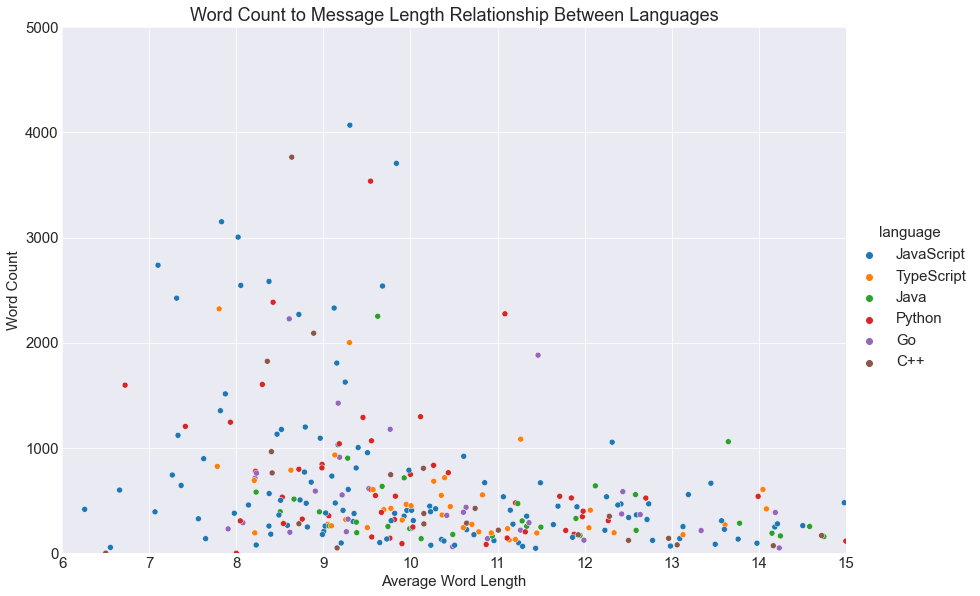

In [47]:
plot = sns.relplot(data = data, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 5000))
plot.set(xlim=(6,15))
plt.title('Word Count to Message Length Relationship Between Languages')#change title
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')

In [48]:
data.groupby('language')['message_length','word_count','sentiment'].agg(['mean','median'])

message_length          word_count        sentiment         
                     mean median         mean median      mean   median
language                                                               
C++           7950.300000   3754   779.633333    280  0.857807  0.98710
Go            9014.944444   4299   761.805556    364  0.733331  0.98955
Java          7136.369565   3417   457.326087    256  0.670570  0.96590
JavaScript    9918.340426   4095   950.808511    408  0.869337  0.99030
Python       11676.101695   5336  1179.101695    525  0.786159  0.98880
TypeScript    4644.422222   3772   455.777778    316  0.899844  0.99150

In [49]:
data.groupby('is_javascript').agg(['mean','median'])

message_length         word_count        avg_word_length  \
                        mean median        mean median            mean   
is_javascript                                                            
False            8283.375000   3940  749.666667    323       12.256531   
True             9918.340426   4095  950.808511    408       11.401769   

                         sentiment          
                  median      mean  median  
is_javascript                               
False          10.723922  0.786374  0.9874  
True           10.032154  0.869337  0.9903

**Takeaway**
Java Script 

## Sentiment Values

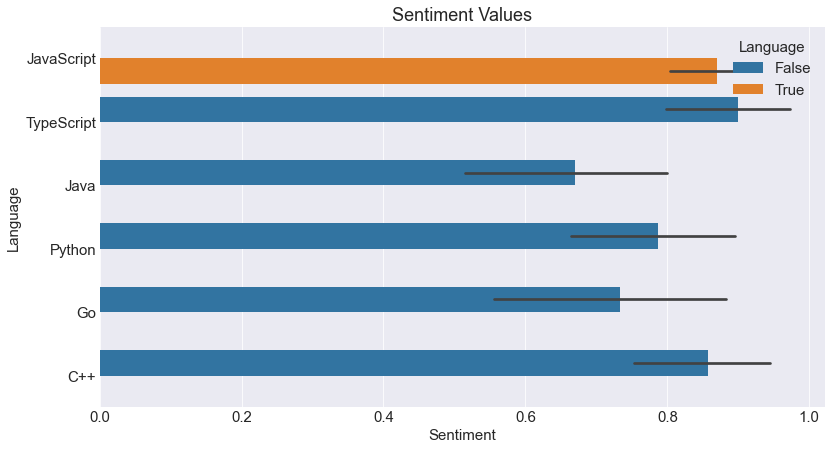

In [50]:
sns.barplot(data = data, x = 'sentiment', y = 'language', hue = 'is_javascript')
plt.title('Sentiment Values')#change title
plt.xlabel('Sentiment')
plt.ylabel('Language')
plt.legend(loc = 'upper right', title = 'Language')

# Modeling

In [51]:
# Bag of words
cv = CountVectorizer()
bag_of_words = cv.fit_transform(data.clean)

In [52]:
bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [53]:
pprint(data)

                                      repo    language  \
3                 tailwindlabs/tailwindcss  JavaScript   
5                             github/fetch  JavaScript   
7                     ianstormtaylor/slate  TypeScript   
8                            Kong/insomnia  JavaScript   
9    CymChad/BaseRecyclerViewAdapterHelper        Java   
..                                     ...         ...   
551                     TheAlgorithms/Java        Java   
555                     tornadoweb/tornado      Python   
557                            gulpjs/gulp  JavaScript   
558                           alibaba/weex         C++   
559                           dmlc/xgboost         C++   

                                                 clean  \
3    utilityfirst cs framework rapidly building cus...   
5    windowfetch polyfill fetch function promisebas...   
7    completely customizable framework building ric...   
8    insomnia rest client slack channelhttpschatins...   
9    httpsuse

In [54]:
# TFIDF 
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(data.clean)

pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names()).sample(20)

,00,000,0000,00000,000000,00000001,0000001,00008384,0001,0001two,...,zxingcpprbhttpsgithubcomglassechidnazxingcpprb,zxingjslibraryhttpsgithubcomzxingjslibrary,zxingobjchttpsgithubcomthelevelupzxingobjc,zxingorg,zyclotropj,zyclotropjhttpsgithubcomzyclotropj,zyedidiamicro,zypehttpsboardsgreenhouseiozype,zypper,zyte
250,0.005726,0.000000,0.0,0.002863,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.055437,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

use                   1.363080
using                 1.482370
support               1.509895
project               1.552657
code                  1.557523
                        ...   
fluxutils             6.187386
flvjs                 6.187386
flvminjs              6.187386
flutter929dart1031    6.187386
zyte                  6.187386
Length: 57624, dtype: float64

In [56]:
data.is_javascript.value_counts(normalize = True)

False    0.605042
True     0.394958
Name: is_javascript, dtype: float64

In [57]:
# Baseline: ~60.5

In [58]:
# Using Clean, Stemmed, lemmatized data on a MultinomialNB, and DecisionTreeClassifier.

In [59]:
# Getting the cleaned data
X = data.clean
y = data.is_javascript

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [60]:
# Cleaned data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_clean)

clf.score(X_bow, y_train_clean)

1.0

In [61]:
# Cleaned data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_clean)

clf.score(X_tfidf, y_train_clean)

1.0

In [62]:
# Cleaned data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_clean)

tree.score(X_bow, y_train_clean)

0.9333333333333333

In [63]:
# Cleaned data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
tree.fit(X_tfidf,y_train_clean)
tree.score(X_tfidf,y_train_clean)

0.9438596491228071

In [64]:
# Getting the stemmed data
X = data.stemmed
y = data.is_javascript

X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [65]:
# Stemmed data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_stemmed)

clf.score(X_bow, y_train_stemmed)

1.0

In [66]:
# Stemmed data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_stemmed)

clf.score(X_tfidf, y_train_stemmed)

1.0

In [67]:
# Stemmed data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_stemmed)

tree.score(X_bow, y_train_stemmed)

0.9263157894736842

In [68]:
# Stemmed data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
tree.fit(X_tfidf,y_train_stemmed)
tree.score(X_tfidf,y_train_stemmed)

0.9438596491228071

In [69]:
# Getting the lemmatized data
X = data.lemmatized
y = data.is_javascript

X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = train_test_split(X, y, test_size=.2, random_state=174,stratify = data.is_javascript)

In [70]:
# Lemmatized data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train_lemmatized)

clf.score(X_bow, y_train_lemmatized)

1.0

In [71]:
# Lemmatized data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train_lemmatized)

clf.score(X_tfidf, y_train_lemmatized)

1.0

In [72]:
# Lemmatized data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train_lemmatized)

tree.score(X_bow, y_train_lemmatized)

0.9263157894736842

In [73]:
# Lemmatized data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
tree.fit(X_tfidf,y_train_lemmatized)
tree.score(X_tfidf,y_train_lemmatized)

0.9438596491228071

In [74]:
tree.score(tfidf.transform(X_test_clean), y_test_clean)

0.7361111111111112

In [75]:
predictions = make_predictions(clf,X_train_clean,X_test_clean,y_train_clean)

In [76]:
# uses count vectorization on the cleaned data and makes a model report on the test predictions using a multinomialNB
model_report(y_test_clean, predictions)


            *** Model  Report ***  
            ---------------------              
 _____________________________________________
|   Positive Case: is javascript = 'false'    |
|   Negative Case: is javascript = 'true'     |
|---------------------------------------------|
|                 Accuracy:   77.78%          |
|       True Positive Rate:   56.25%          |
|      False Positive Rate:   33.93%          |
|       True Negative Rate:   66.07%          |
|      False Negative Rate:   43.75%          |
|                Precision:   73.08%          |
|                   Recall:   67.86%          |
|                 F1-Score:   70.37%          |
|                                             |
|         Positive Support:       28          |
|         Negative Support:       44          |
|            Total Support:       72          |
|_____________________________________________|

